## Prompts Exploratory Data Analysis
Using this notebook, we can analyze and extract key insights from the prompts used for training our LLM model.

#### EDA Overview
Token Wise:
- Average Tokens Length
- Token Lengths Distribution
- Min/Max in tokens

Coverage:
- Prompt Coverage as a function of Tokens Lenght
- Prompt Coverage as a function of hardcoded LLM context size.

Word Analysis:
- Word Cloud
---

### Insights:
- `Average Tokens Length` : see wether our prompts are balanced in relation to model context size.
- `Token Lengths Distribution` : see variety of sentence lengths, skewed towards short or long sentences
- `Min/Max in tokens` : anomalies or outliers in the training set

- `Prompt Coverage w.r.t Tokens Lenght` : how effective the prompts cover the entire range of tokens lengths
- `Word Cloud` : main topics and subjects within the dataset

In [ ]:
# Setup Dependencies
! pip install seaborn matplotlib datasets transformers wordcloud

In [2]:
# Load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
tokenizer.eos_token = "EOS"
tokenizer.pad_token = "UNK"
print(f"Loaded Tokenizer : {tokenizer}" if tokenizer else "Failed to load")

Loaded Tokenizer : BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': 'EOS', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': 'UNK', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [3]:
# Prepare training data parser
from enum import Enum
from pathlib import Path
from datasets import load_dataset
from dataclasses import dataclass, field

class Scope(Enum):
    TRAIN = "train"

@dataclass
class DataSample:
    about_me: str = field(repr=False)
    context: str = ""
    response: str = ""
    
    def formatted(self):
        """Train containing raw text fields"""
        template = """
        {ABOUT}
        {CONTEXT}
        {RESPONSE}
        """
        complete = template.format(ABOUT=self.about_me, CONTEXT=self.context, RESPONSE=self.response)
        return complete

class DatasetGenerator:
    def __init__(self, dataset_file_path: Path, scope: Scope):
        self._scope = scope
        self.tokenizer = tokenizer
        self.dataset = self._load_dataset(dataset_file_path)
    
    @property
    def size(self):
        return len(self.dataset[self._scope.value])
    
    def _load_dataset(self, dataset_file_path: Path):
        try:
            dataset = load_dataset("json", data_files=str(dataset_file_path))
            print("=" * 10 + " Info " + "=" * 10)
            print(f"Dataset Path : {dataset_file_path}")
            print(f"Loaded : {len(dataset[self._scope.value])} samples.")
            return dataset
        except FileNotFoundError:
            print("JSON file not found.")
            raise FileNotFoundError("Check the file path")
        except SyntaxError:
            print("JSON file badly formatted.")
            raise FileNotFoundError("Forgot how to write json")

    def tokenized_samples(self, tokenizer):
        """Iterates through the dataset prompts, tokenizes and saves a stores a sublist
        of tokens for each prompt."""
        formatted_samples = list(map(lambda en: DataSample(**en), self.dataset[self._scope.value]))
        tokenized_samples = []
        for sample in formatted_samples:
            as_str = sample.formatted()
            tokenized = tokenizer(as_str)
            tokenized = tokenized["input_ids"]
            tokenized_samples.append(tokenized)
        return tokenized_samples
            
    def samples_gen(self):
        formatted_samples = list(map(lambda en: DataSample(**en), self.dataset[self._scope.value]))
        for sample in formatted_samples:
            yield sample


In [4]:

# 1. Prerequisites
DATASET_ROOT = Path("../modules/q_and_a_dataset_generator/data")
dataset_json_file = DATASET_ROOT / "training_data.json"


# 2. Prepare dataset
dataset = DatasetGenerator(dataset_file_path=dataset_json_file, scope=Scope.TRAIN)
tokenized_samples = dataset.tokenized_samples(tokenizer)

Generating train split: 102 examples [00:00, 39863.87 examples/s]

========== Info ==========
Dataset Path : ../modules/q_and_a_dataset_generator/data/training_data.json
Loaded : 102 samples.


### EDA-01 Tokens Based
- Average Tokens Length
  - Check the average length in tokens of your fine-tuning prompts. Helps to identify the overall context-window you can aim for.
- Token Lengths Distribution
  - Visually inspect which context-window size covers all your fine-tuning dataset.
- Min/Max Token Distributions + (25-75) Percentiles
  - Verbose representation of tokens lengths of your fine-tuning dataset.

In [5]:
# Average Tokens Length
import numpy as np
toks_mean = np.mean([len(x) for x in tokenized_samples])
print(f"Average Prompt Lenght : {toks_mean:.0f} tokens")


Average Prompt Lenght : 136 tokens


Using arbitrary: MinTokenLimit = 128 toks.
Using arbitrary: MaxTokenLimit = 256 toks


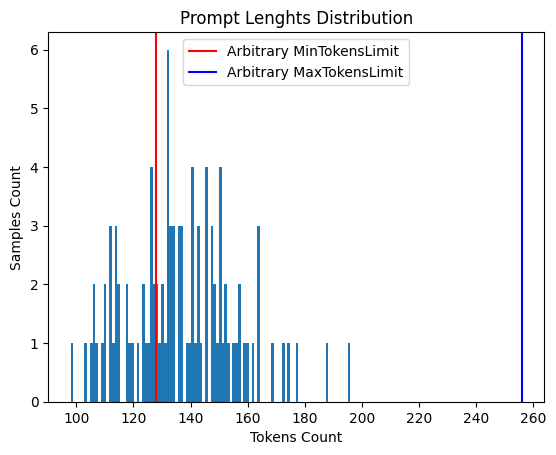

In [6]:
# Token Lengths Distribution
import matplotlib.pyplot as plt

lens = [len(x) for x in tokenized_samples]
min_toks_bar = 128
max_toks_bar = 256
plt.hist(lens, bins=len(tokenized_samples))
plt.title("Prompt Lenghts Distribution")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
print(f"Using arbitrary: MinTokenLimit = {min_toks_bar} toks.")
print(f"Using arbitrary: MaxTokenLimit = {max_toks_bar} toks")
plt.axvline(min_toks_bar, color="red", label="Arbitrary MinTokensLimit")
plt.axvline(max_toks_bar, color="blue", label="Arbitrary MaxTokensLimit")
plt.legend()
plt.show()


In [7]:
# Percentiles .25 .5 .75
import numpy as np
lens = [len(x) for x in tokenized_samples]
print(f"Minimum Prompt Lenght : {np.min(lens)} tokens")
print(f"Maximum Prompt Lenght : {np.max(lens)} tokens")

p25, p50, p75 = np.percentile(lens, [25, 50, 75])
print(f"25th percentile: {p25:.0f} tokens")
print(f"50th (median) percentile: {p50:.0f} tokens")
print(f"75th percentile: {p75:.0f} tokens")

Minimum Prompt Lenght : 98 tokens
Maximum Prompt Lenght : 196 tokens
25th percentile: 124 tokens
50th (median) percentile: 135 tokens
75th percentile: 148 tokens


### EDA-02 Prompt Coverage Based
- Prompt Coverage as a function of Tokens Length
  - Establishing a context-window size, inspect the prompts tokens distribution of the dataset that fits within the selected window.

Min selected ctx-window: 128 toks
Max selected ctx-window: 256 toks


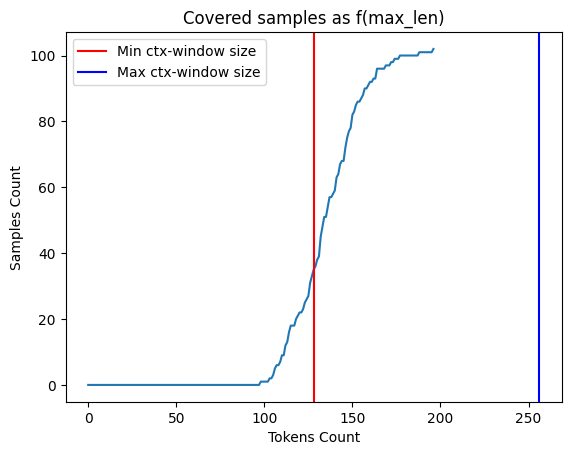

In [8]:
# Plot tokens distributions
plt.plot([len([l for l in lens if l <= m]) for m in range(max(lens) + 1)])
context_window_p1 = 128
context_window_p2 = 256
print(f"Min selected ctx-window: {context_window_p1} toks")
print(f"Max selected ctx-window: {context_window_p2} toks")
plt.title("Covered samples as f(max_len)")
plt.xlabel("Tokens Count")
plt.ylabel("Samples Count")
plt.axvline(x=context_window_p1, color="red", label="Min ctx-window size")
plt.axvline(x=context_window_p2, color="blue", label="Max ctx-window size")
plt.legend()
plt.show()

### EDA-03 Prompt lengths boxplot
- Median: This line shows the median value of token lengths in each interval. Inspect the central tendency.
- Box Length: A larger box suggests greater variability in prompt lengths within that interval.
- Out-bound lines: They represent the range of the data.
- Points outside the whiskers are outliers. Unusually long/short compared to the existing values within that interval.

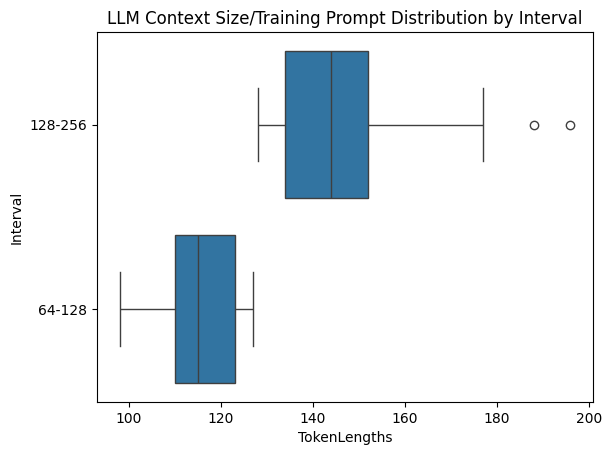

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


intervals = [(0, 64), (64, 128), (128, 256)]

data = []
for length in lens:
    for start, end in intervals:
        if start <= length < end:
            data.append({'TokenLengths': length, 'Interval': f'{start}-{end}'})
            break

df = pd.DataFrame(data)

sns.boxplot(x='TokenLengths', y='Interval', data=df)
plt.title('LLM Context Size/Training Prompt Distribution by Interval')
plt.show()


### EDA-04 WordCloud Analysis
- Visual representation of most representative words
- Helps in preventing bias towards a specific theme (overfit)
- Helps into processing/removing irrelevant frequent words
- Could serve as a basic quality check of your overall dataset vocabulary

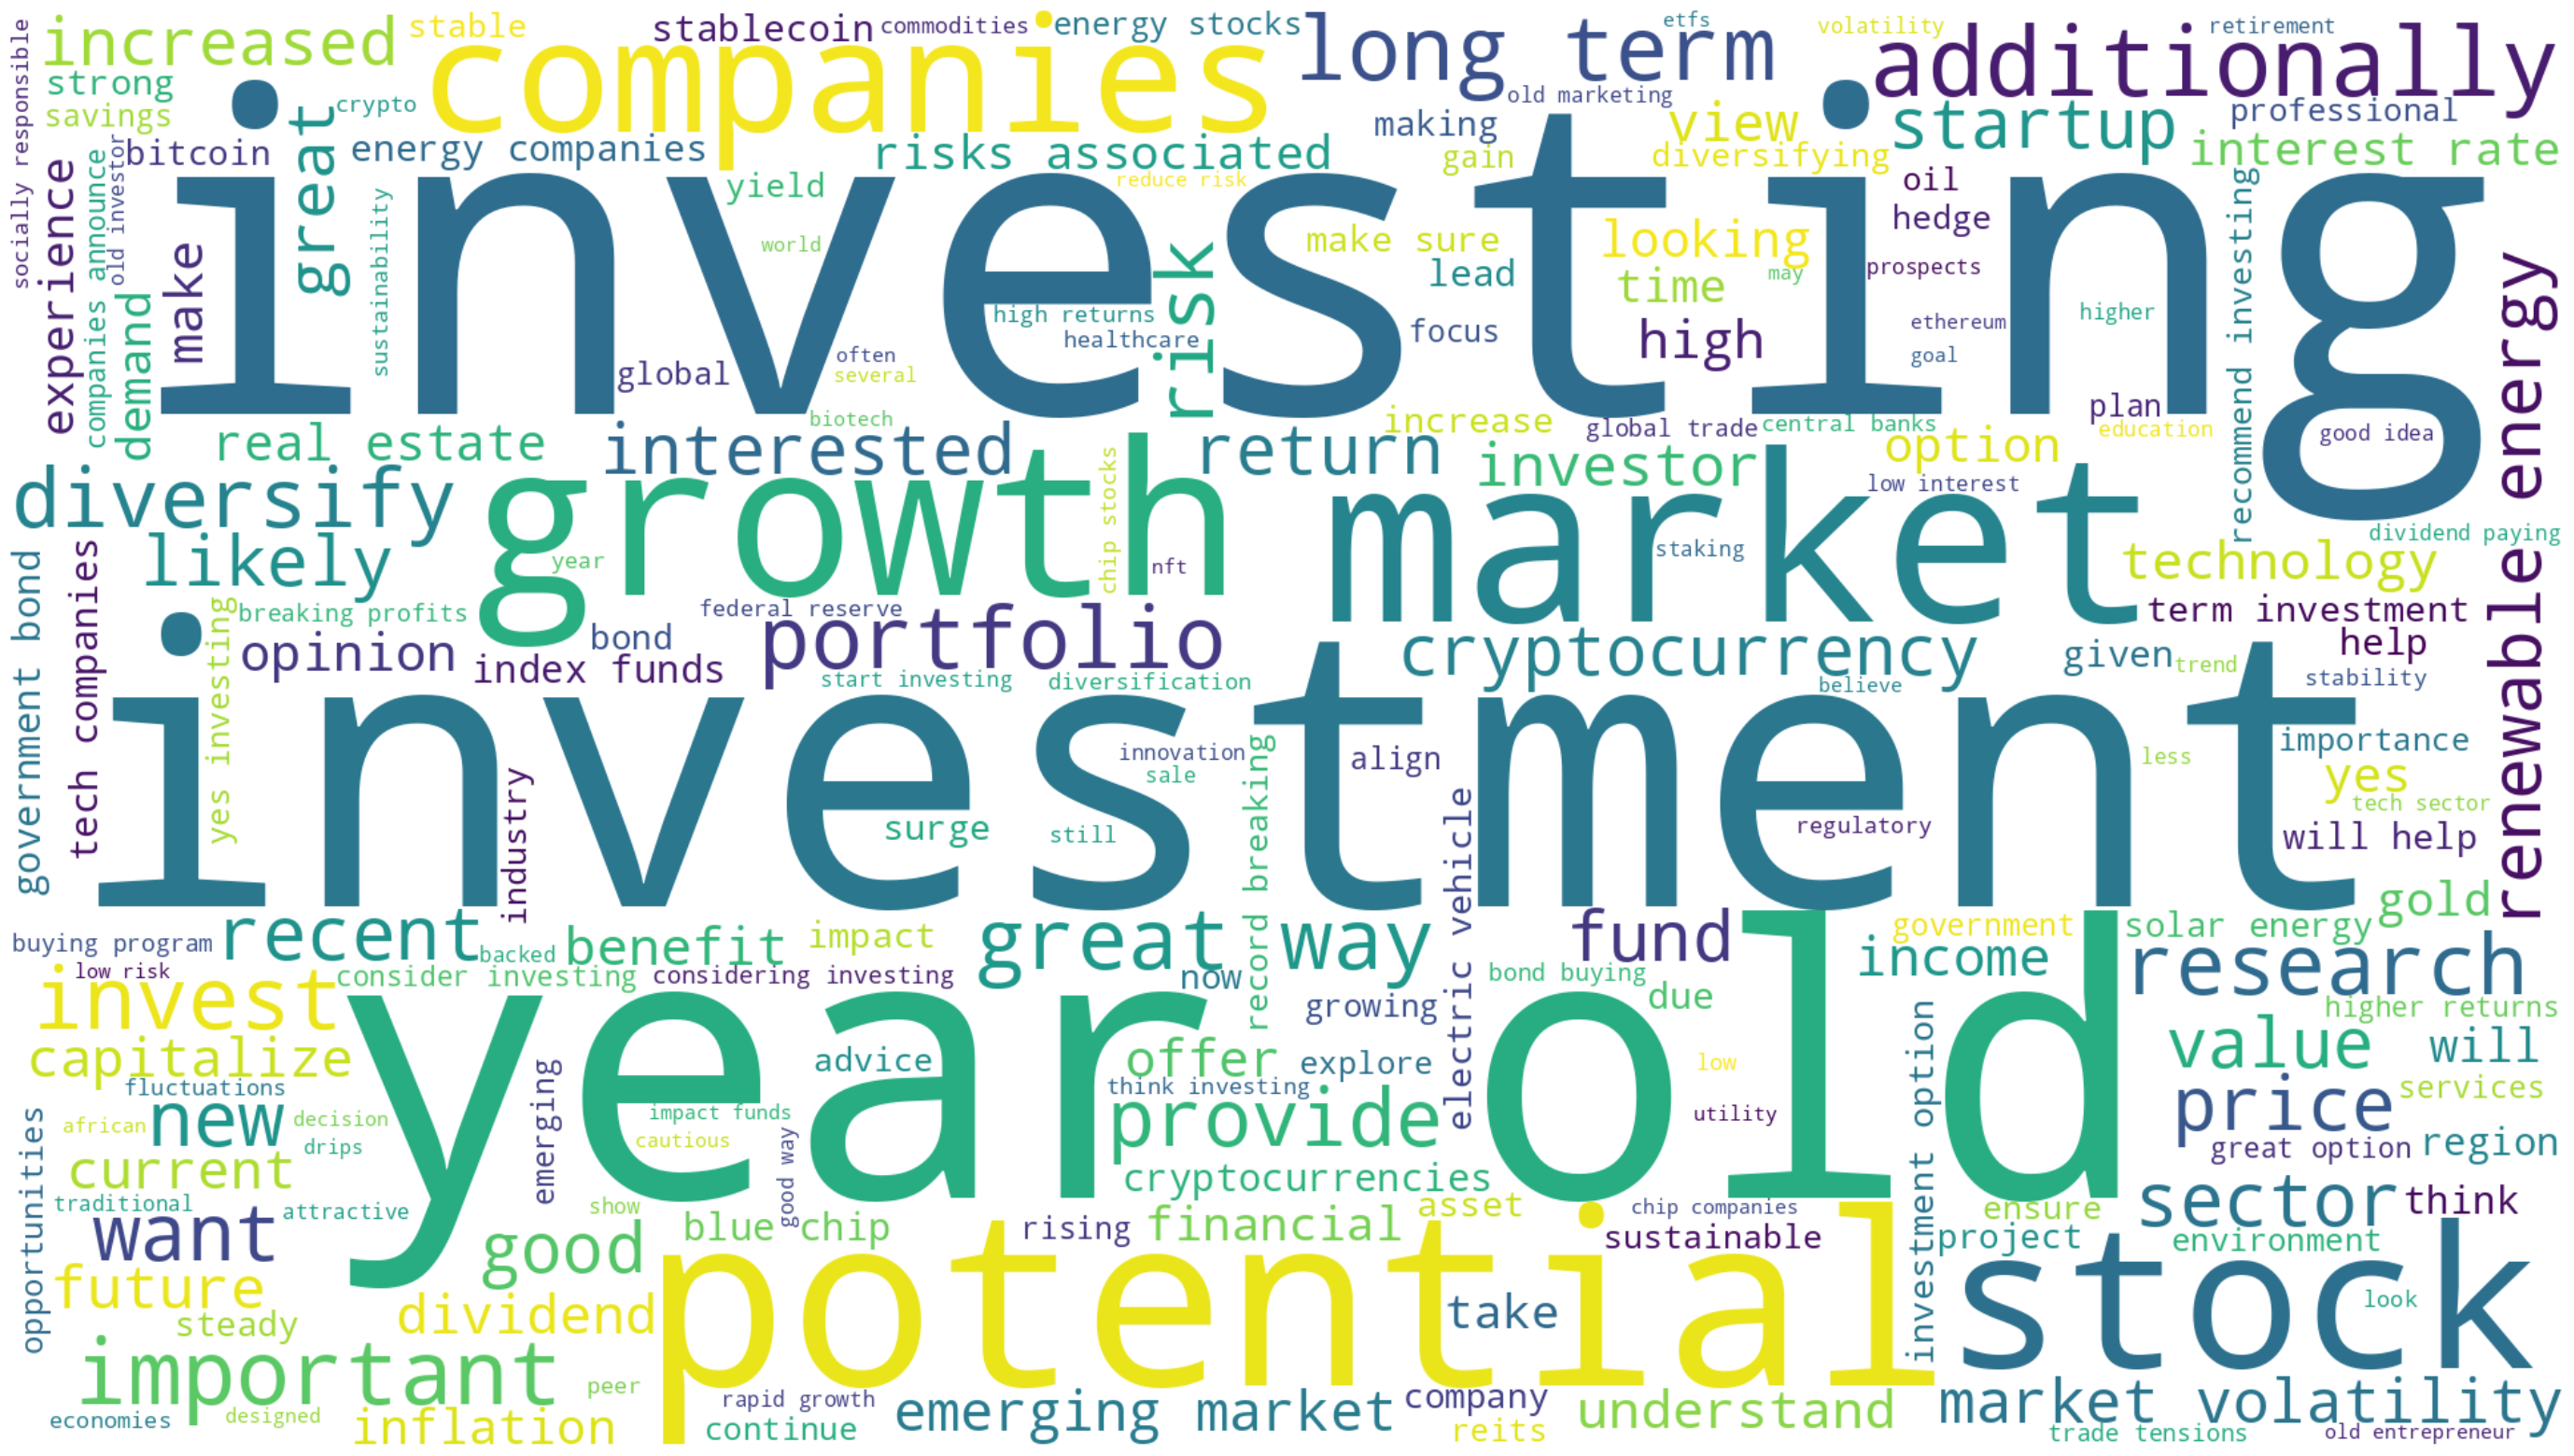

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
generator = dataset.samples_gen()
for sample in generator:
    text += sample.formatted()
text = text.lower().replace('.', '').replace(',', '')

wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(text)

plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
